In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
from collections import OrderedDict
import pylhe
import glob
import pyslha

delphesDir = os.path.abspath("/home/camila/MG5/Delphes")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps.get_cmap('RdYlBu')

Welcome to JupyROOT 6.26/10


### Set delphes files

In [2]:
inputFiles = {'off-shell': ['/home/camila/MonoXSMS/Tests/DMSimp_axial_0j_gm_005/Events/run_01/axial_3000_1_delphes_events.root'],
              'on-shell': ['/home/camila/MonoXSMS/Tests/DMSimp_axial_0j_gm_onshell_005/Events/run_01/axial_3000_1_delphes_events.root']
              }

### Load Model Parameters

In [3]:
parameters = {}
for label,file in inputFiles.items():
    banner = list(glob.glob(os.path.dirname(file[0])+'/*banner.txt'))
    if len(banner) != 1:
        print('%i banner files found for %s!' %(len(banner),label))
        break
    else:
        banner = banner[0]
    xtree = ET.parse(banner)
    xroot = xtree.getroot()
    xsecPB = eval(xroot.find('init').text.split()[-2])
    slha = xroot.find('header').find('slha').text
    pars = pyslha.readSLHA(slha)
    mMed = pars.blocks['MASS'][55]
    mDM = pars.blocks['MASS'][52]
    wMed = pars.decays[55].totalwidth
    gVq = pars.blocks['DMINPUTS'][4] # Mediator-quark vector coupling
    gAq = pars.blocks['DMINPUTS'][10] # Mediator-quark axial coupling
    gVx = pars.blocks['DMINPUTS'][2] # Mediator-DM vector coupling
    gAx = pars.blocks['DMINPUTS'][3] # Mediator-DM axial coupling
    parameters[label] = {'xsec(pb)' : xsecPB, 'mMed' : mMed, 'mDM' : mDM, 
                         'gVq' : gVq, 'gAq' : gAq, 'gVx' : gVx, 'gAx' : gAx, 'wMed': wMed}
    print(label,': mMed = %1.2f GeV, mDM = %1.2f GeV, cross-section = %1.3e pb' %(mMed,mDM,xsecPB))

off-shell : mMed = 3000.00 GeV, mDM = 1.00 GeV, cross-section = 3.917e-02 pb
on-shell : mMed = 3000.00 GeV, mDM = 1.00 GeV, cross-section = 2.696e-02 pb


### Load events, get parton level invariant mass

In [4]:
# ## Cuts
## MET
minMET = 250.
pTcut = 150.

In [5]:
weights = {label : np.array([]) for label in inputFiles}
invmasses = {label : np.array([]) for label in inputFiles}
genMet = {label : np.array([]) for label in inputFiles}
totalweight = {label : 0.0 for label in inputFiles}
totalweightPB = 0.
    
for label,files in inputFiles.items():
    for file in files:

        f = ROOT.TFile(file,'read')
        tree = f.Get("Delphes")
        nevts = tree.GetEntries()
        parameters[label]['Events'] = nevts

        for ievt in range(nevts):    
            tree.GetEntry(ievt)     
            weight = tree.Weight.At(1).Weight

            if weight >= 0:
                totalweight[label] += weight
            
            missingET = tree.GenMissingET.At(0)  # USE REAL MISSING ET!
            
            
            if missingET.MET < pTcut:
                continue
                
            if missingET.MET < minMET:
                continue
                
            DM1 = tree.dmParticles.At(0)
            DM2 = tree.dmParticles.At(1)
            
            invmass2 = (DM1.E + DM2.E)**2 - (DM1.Px + DM2.Px + DM1.Py + DM2.Py + DM1.Pz + DM2.Pz)**2
            invmass = np.sqrt(invmass2) if invmass2 >= 0 else 0
            

            weights[label] = np.append(weights[label],totalweightPB)
            invmasses[label] = np.append(invmasses[label],invmass)
            genMet[label] = np.append(genMet[label],missingET.MET)

        f.Close()

### Total cross-sections

In [6]:
for label,w in totalweight.items():
    print(label,'total cross-section = %1.3e pb (%i events)' %(w,parameters[label]['Events']))
colors = {label : sns.color_palette('deep')[i+1] for i,label in enumerate(weights.keys())}  

off-shell total cross-section = 3.562e-02 pb (93826 events)
on-shell total cross-section = 2.385e-02 pb (92230 events)


### Plot invariant mass distributions (parton level)

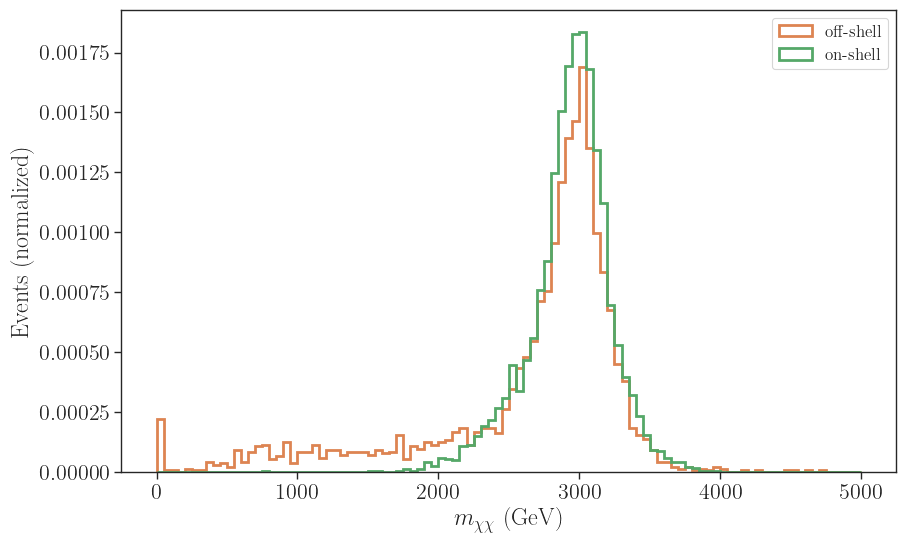

In [7]:
fig = plt.figure(figsize=(10,6))
for label,pt in invmasses.items():
    binc,binEdges,patches = plt.hist(pt,bins=np.linspace(0,5000,101),
                               label=label,histtype='step',color=colors[label],linewidth=2, density=True)


    
# plt.yscale('log')
# plt.ylim(1e-7,3e-2)
plt.xlabel(r'$m_{\chi \chi}$ (GeV)')
plt.ylabel(r'Events (normalized)')
# plt.xlim(200,2500)
plt.legend(loc='upper right', fontsize='x-small')
plt.show()

### make cut on invariant mass for off-shell events using bwcutoff $=5$

In [8]:
weights['off-shell (cut)'] = np.array([])
invmasses['off-shell (cut)'] = np.array([])

In [9]:
for file in inputFiles['off-shell']:

    f = ROOT.TFile(file,'read')
    tree = f.Get("Delphes")
    nevts = tree.GetEntries()
    parameters[label]['Events'] = nevts

    for ievt in range(nevts):    
        tree.GetEntry(ievt)     
        weight = tree.Weight.At(1).Weight

        if weight >= 0:
            totalweight[label] += weight

        missingET = tree.GenMissingET.At(0)  # USE REAL MISSING ET!


        if missingET.MET < pTcut:
            continue

        if missingET.MET < minMET:
            continue

        DM1 = tree.dmParticles.At(0)
        DM2 = tree.dmParticles.At(1)

        invmass2 = (DM1.E + DM2.E)**2 - (DM1.Px + DM2.Px + DM1.Py + DM2.Py + DM1.Pz + DM2.Pz)**2
        invmass = np.sqrt(invmass2) if invmass2 >= 0 else 0

        wMed = parameters['off-shell']['wMed']
        mMed = parameters['off-shell']['mMed']
        bwcutoff = 5

        if invmass < (mMed - bwcutoff*wMed) or invmass > (mMed + bwcutoff*wMed):
            continue


        weights['off-shell (cut)'] = np.append(weights['off-shell (cut)'],totalweightPB)
        invmasses['off-shell (cut)'] = np.append(invmasses['off-shell (cut)'],invmass)

    f.Close()

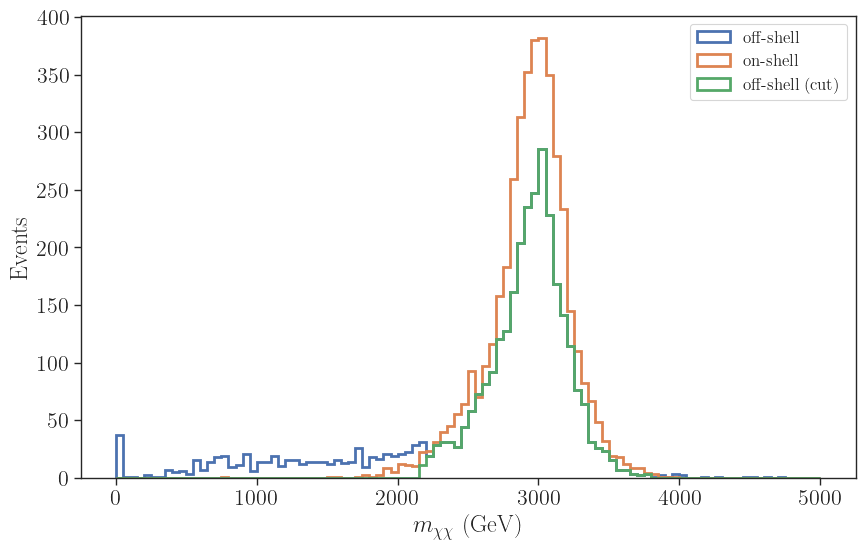

In [13]:
fig = plt.figure(figsize=(10,6))
for label,pt in invmasses.items():
    binc,binEdges,patches = plt.hist(pt,bins=np.linspace(0,5000,101),
                               label=label,histtype='step',linewidth=2, density=False)


    
# plt.yscale('log')
# plt.ylim(1e-7,3e-2)
plt.xlabel(r'$m_{\chi \chi}$ (GeV)')
plt.ylabel(r'Events')
# plt.xlim(200,2500)
plt.legend(loc='upper right', fontsize='x-small')
plt.show()

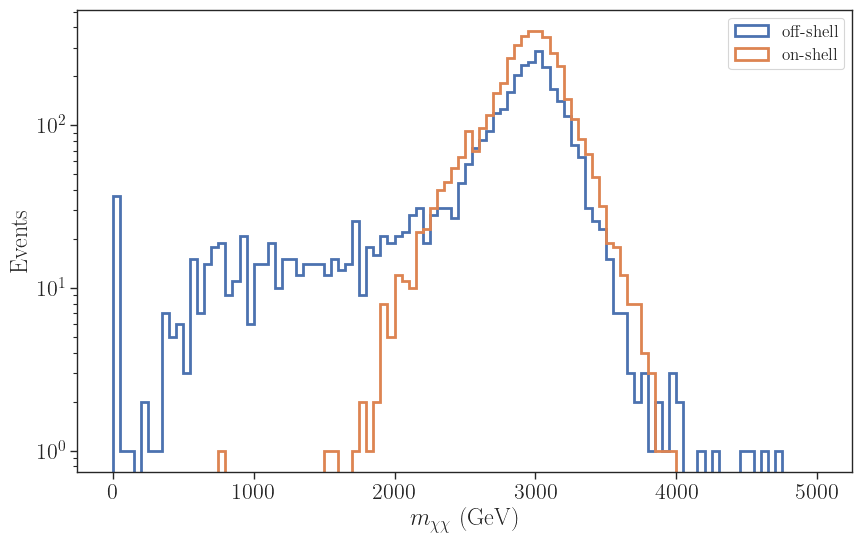

In [11]:
fig = plt.figure(figsize=(10,6))
for label,pt in invmasses.items():
    if 'on-shell' in label:
        bincOn,binEdges,patches = plt.hist(pt,bins=np.linspace(0,5000,101),
                                   label=label,histtype='step',linewidth=2, density=False)
    if '(cut)' not in label and 'off-shell' in label:
        bincOff,binEdges,patches = plt.hist(pt,bins=np.linspace(0,5000,101),
                                   label=label,histtype='step',linewidth=2, density=False)


    
plt.yscale('log')
# plt.ylim(1e-7,3e-2)
plt.xlabel(r'$m_{\chi \chi}$ (GeV)')
plt.ylabel(r'Events')
# plt.xlim(200,2500)
plt.legend(loc='upper right', fontsize='x-small')
plt.show()